In [1]:
%matplotlib notebook

import json_lines
from collections import defaultdict

import jieba
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

import numpy as np
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

font = font_manager.FontProperties(fname='msjh.ttc', size=14)
sns.set(style='whitegrid')

In [2]:
# load ptt posts

path = 'output\Gossiping-10000.json'

# with open(path, 'rb') as f:
#     for post in json_lines.reader(f):
#         print(post['title'])

# Comment Analysis

In [3]:
# get pushes

total_comments = defaultdict(int)
total_pushes = defaultdict(int)
total_hates = defaultdict(int)

with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        for comment in post['comments']:
            user = comment['user']
            total_comments[user] += 1

            if comment['score'] > 0:
                total_pushes[user] += 1

            elif comment['score'] < 0:
                total_hates[user] += 1

In [4]:
def show_distributions(counts, pushes, hates):
    sorted_cnts = [t[0] for t in sorted(counts.items(), key=lambda x: -x[1])][:100]
    y = [counts[u] for u in sorted_cnts]
    y_pushes = [pushes[u] for u in sorted_cnts]
    y_hates = [hates[u] for u in sorted_cnts]
    x = range(len(y))
    top_names = [x for x in sorted_cnts]
    
    f, ax = plt.subplots(figsize=(10, 6))
    
    sns.set_color_codes('pastel')
    sns.plt.plot(x, y, label='Total {}'.format('comments'), color='blue')
    sns.plt.plot(x, y_pushes, label='Total {}'.format('pushes'), color='green')
    sns.plt.plot(x, y_hates, label='Total {}'.format('hates'), color='red')
    
    ax.legend(ncol=3, loc='upper right', frameon=True)
    ax.set(ylabel='counts',
           xlabel='',
           title='Total comments')
#     ax.set_xticklabels(top_names, rotation=0, fontproperties=font)
    sns.despine(left=True, bottom=True)

    plt.show(f)
    for user in top_names:
        print(user)

<IPython.core.display.Javascript object>


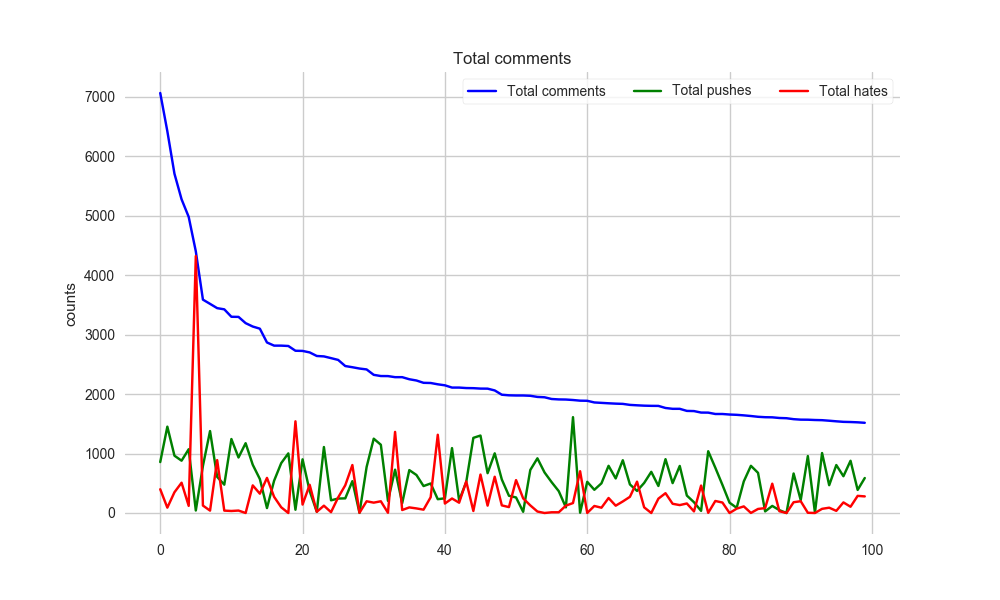

formatted
VVizZ
JingP
Rrrxddd
VOLK11
GGrunrundela
Nikon610
Dinenger
louis10452
hankdai
Tchachavsky
arrenwu
hongtm
meredith001
event1408472
k44754
GSHARP
wuyiulin
sd09090
highyes
DataMaster
stayawesome
around14357
kmtlikeslave
peterwww
david1230
bonfferoni
Mesenne
ev331
chong17
Mayinggo
g8330330
jma306
deepdish
kent
darkbrigher
kuninaka
Howard61313
gankgf
xjp004123
james732
remarkand
ymuit
sclbtlove
a94037501
kiminocodo
KingKingCold
Whitening
a000000000
linceass
lolic
savetheworld
taikonkimo
superflyy
JackTheRippe
zeumax
CenaC
wowpoqwow
SHIU0315
shevchen
qekezfeed
serding
leamaSTC
maple0425
frommr
f124
henry3744
limoncool
mhlee
jyekid
demitri
silentence
blaz
tamama000
Sony2470GM
realtw
tim121507
ImBBCALL
wasijohn
logitech2004
a216832
Newtype
popy8789
kutkin
clark2644
pojohn
yuugen2
lien
drigo
aggressorX
mengertsai
s505015
mayjan
Tattoo
caesst85149
SupCat
jeter17
etiennechiu
diabolica
goldman0204


In [5]:
# display pushes
show_distributions(total_comments, total_pushes, total_hates)

# Word Analysis

In [6]:
# grap post
words = []
scores = []

with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        d = defaultdict(int)
        content = post['content']
        if post['score'] != 0:
            for l in content.split('\n'):
                if l:
                    for w in jieba.cut(l):
                        d[w] += 1
            if len(d) > 0:
                words.append(d)
                scores.append(1 if post['score'] > 0 else 0)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\蔡奇宏\AppData\Local\Temp\jieba.cache
Loading model cost 0.677 seconds.
Prefix dict has been built succesfully.


In [7]:
# grap comments
c_words = []
c_scores = []

with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        for comment in post['comments']:
            l = comment['content'].strip()
            if l and comment['score'] != 0:
                d = defaultdict(int)
                for w in jieba.cut(l):
                    d[w] += 1
                if len(d) > 0:
                    c_scores.append(1 if comment['score'] > 0 else 0)
                    c_words.append(d)

In [8]:
# convert to vectors
dvec = DictVectorizer()
tfidf = TfidfTransformer()
X = tfidf.fit_transform(dvec.fit_transform(words))

c_dvec = DictVectorizer()
c_tfidf = TfidfTransformer()
c_X = c_tfidf.fit_transform(c_dvec.fit_transform(c_words))

In [9]:
svc = LinearSVC()
svc.fit(X, scores)

c_svc = LinearSVC()
c_svc.fit(c_X, c_scores)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [10]:
def display_top_features(weights, names, top_n, select=abs):
    
    
    top_features = sorted(zip(weights, names), key=lambda x: select(x[0]), reverse=True)[:top_n]
    top_weights = [x[0] for x in top_features]
    top_names = [x[1] for x in top_features]

    fig, ax = plt.subplots(figsize=(10,8))
    ind = np.arange(top_n)
    bars = ax.bar(ind, top_weights, color='blue', edgecolor='black')
    for bar, w in zip(bars, top_weights):
        if w < 0:
            bar.set_facecolor('red')
   
    width = 0.30
    ax.set_xticks(ind + width)
    ax.set_xticklabels(top_names, rotation=90, fontproperties=font)

    plt.show(fig)
    
    for word in top_names:
        print (word)

<IPython.core.display.Javascript object>


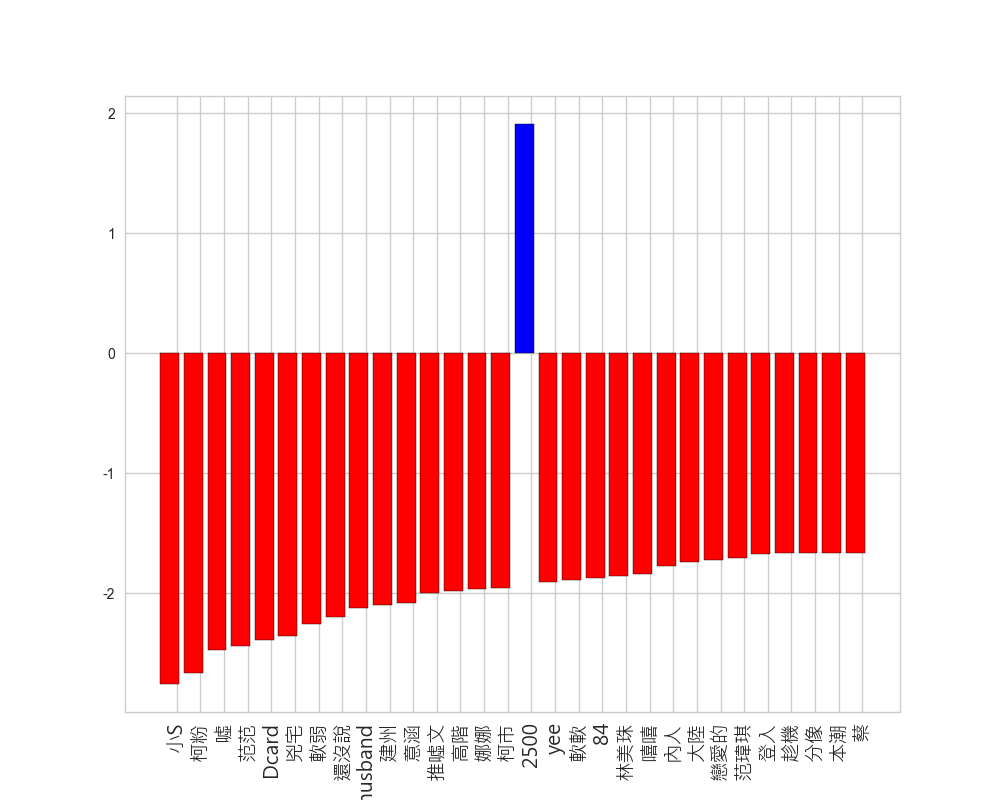

小S
柯粉
噓
范范
Dcard
兇宅
軟弱
還沒說
IUhusband
建州
意涵
推噓文
高階
娜娜
柯市
2500
yee
軟軟
84
林美珠
嘻嘻
內人
大陸
戀愛的
范瑋琪
登入
趁機
分像
本潮
蔡


In [11]:
# top features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


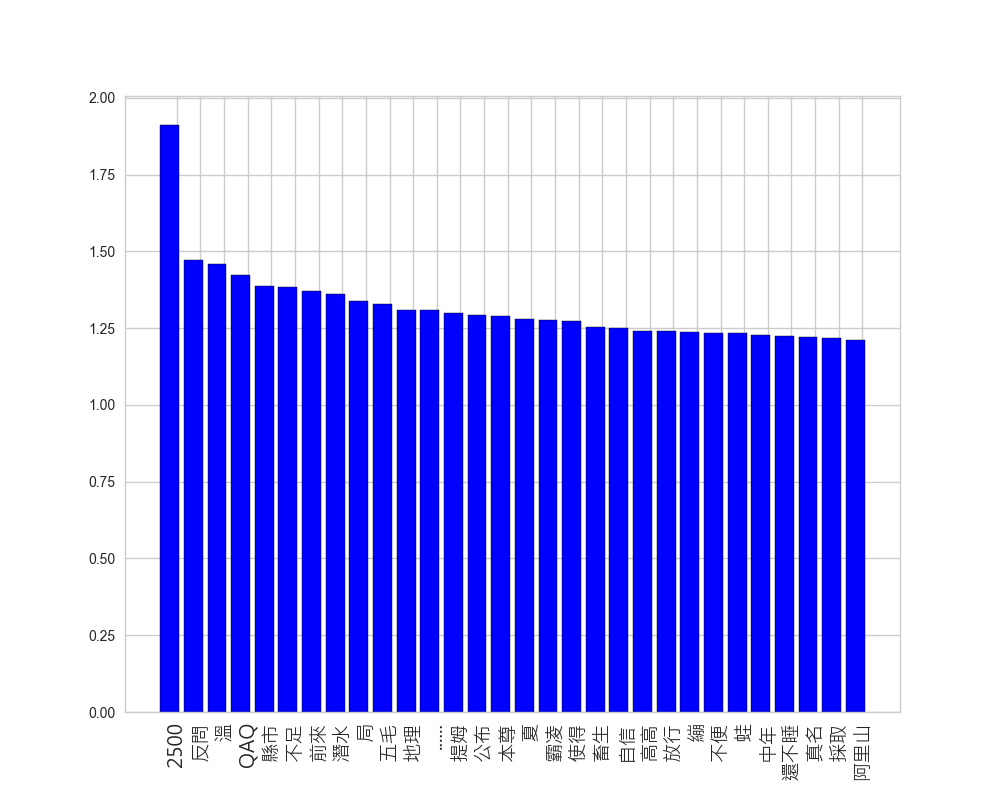

2500
反問
溫
QAQ
縣市
不足
前來
潛水
局
五毛
地理
......
提姆
公布
本尊
夏
霸凌
使得
畜生
自信
高高
放行
繃
不便
蛙
中年
還不睡
真名
採取
阿里山


In [12]:
# top positive features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30, select=lambda x: x)

<IPython.core.display.Javascript object>


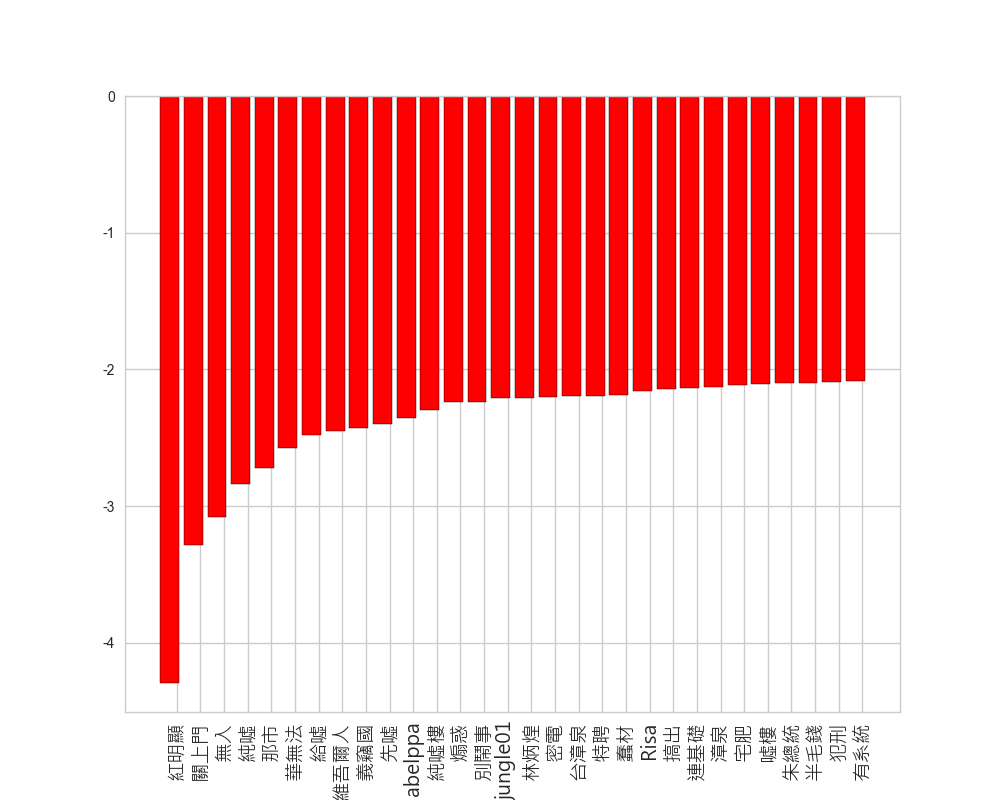

紅明顯
關上門
無入
純噓
那市
華無法
給噓
維吾爾人
義竊國
先噓
abelppa
純噓樓
煽惑
別鬧事
jungle01
林炳煌
密電
台漳泉
特聘
蠢材
Risa
搞出
連基礎
漳泉
宅肥
噓樓
朱總統
半毛錢
犯刑
有系統


In [13]:
# top features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


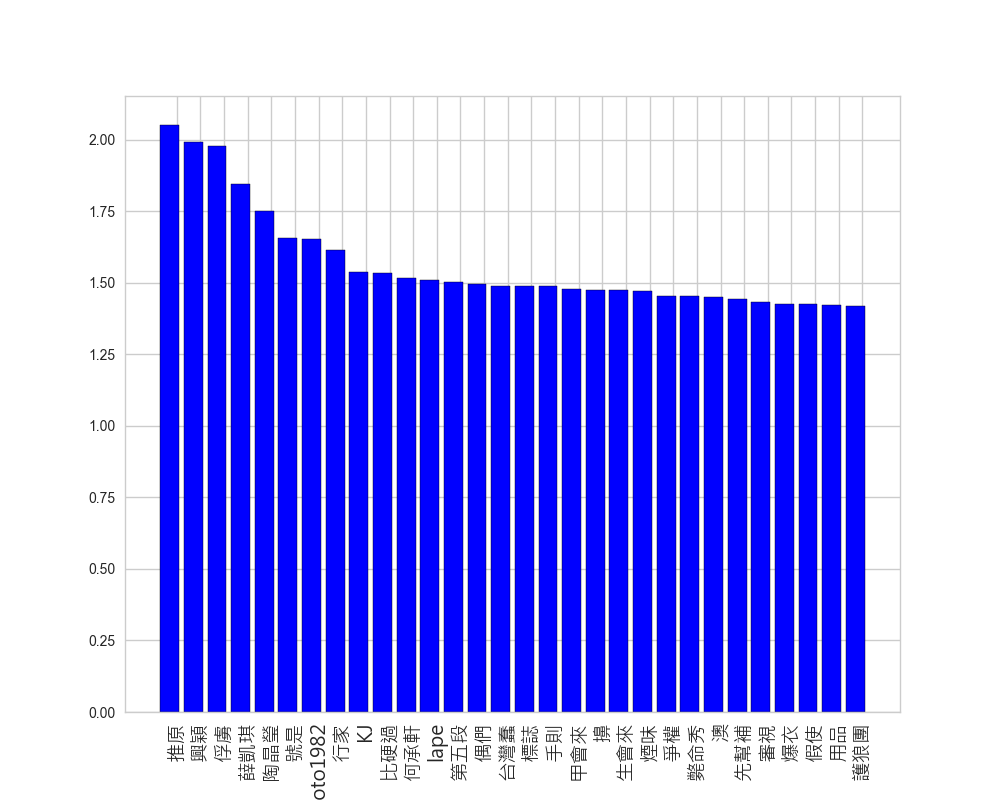

推原
興穎
俘虜
薛凱琪
陶晶瑩
號是
makoto1982
行家
KJ
比硬過
何承軒
lape
第五段
偶們
台灣蠢
標誌
手則
甲會來
擤
生會來
煙味
爭權
斃命秀
澳
先幫補
審視
爆衣
假使
用品
護狼團


In [14]:
# top positive features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30, select=lambda x: x)